In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

plt.style.use("fivethirtyeight")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    
)
plt.rc(
    "lines",
    linewidth = 2
)
%config InlineBackend.figure_format = 'retina'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holiday_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train_data = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/train.csv',
    index_col='date',
    parse_dates=['date'],
)
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [3]:
print(f'Train data dimensions: {train_data.shape}')
print(f'Test data dimensions: {test_data.shape}')

Train data dimensions: (3000888, 5)
Test data dimensions: (28512, 5)


In [4]:
train_data.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [5]:
sales_per_store = pivot_table = pd.pivot_table(train_data, values='sales', index='date', columns=['store_nbr'],aggfunc="sum")
sales_per_store.index.to_period("D")

PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)

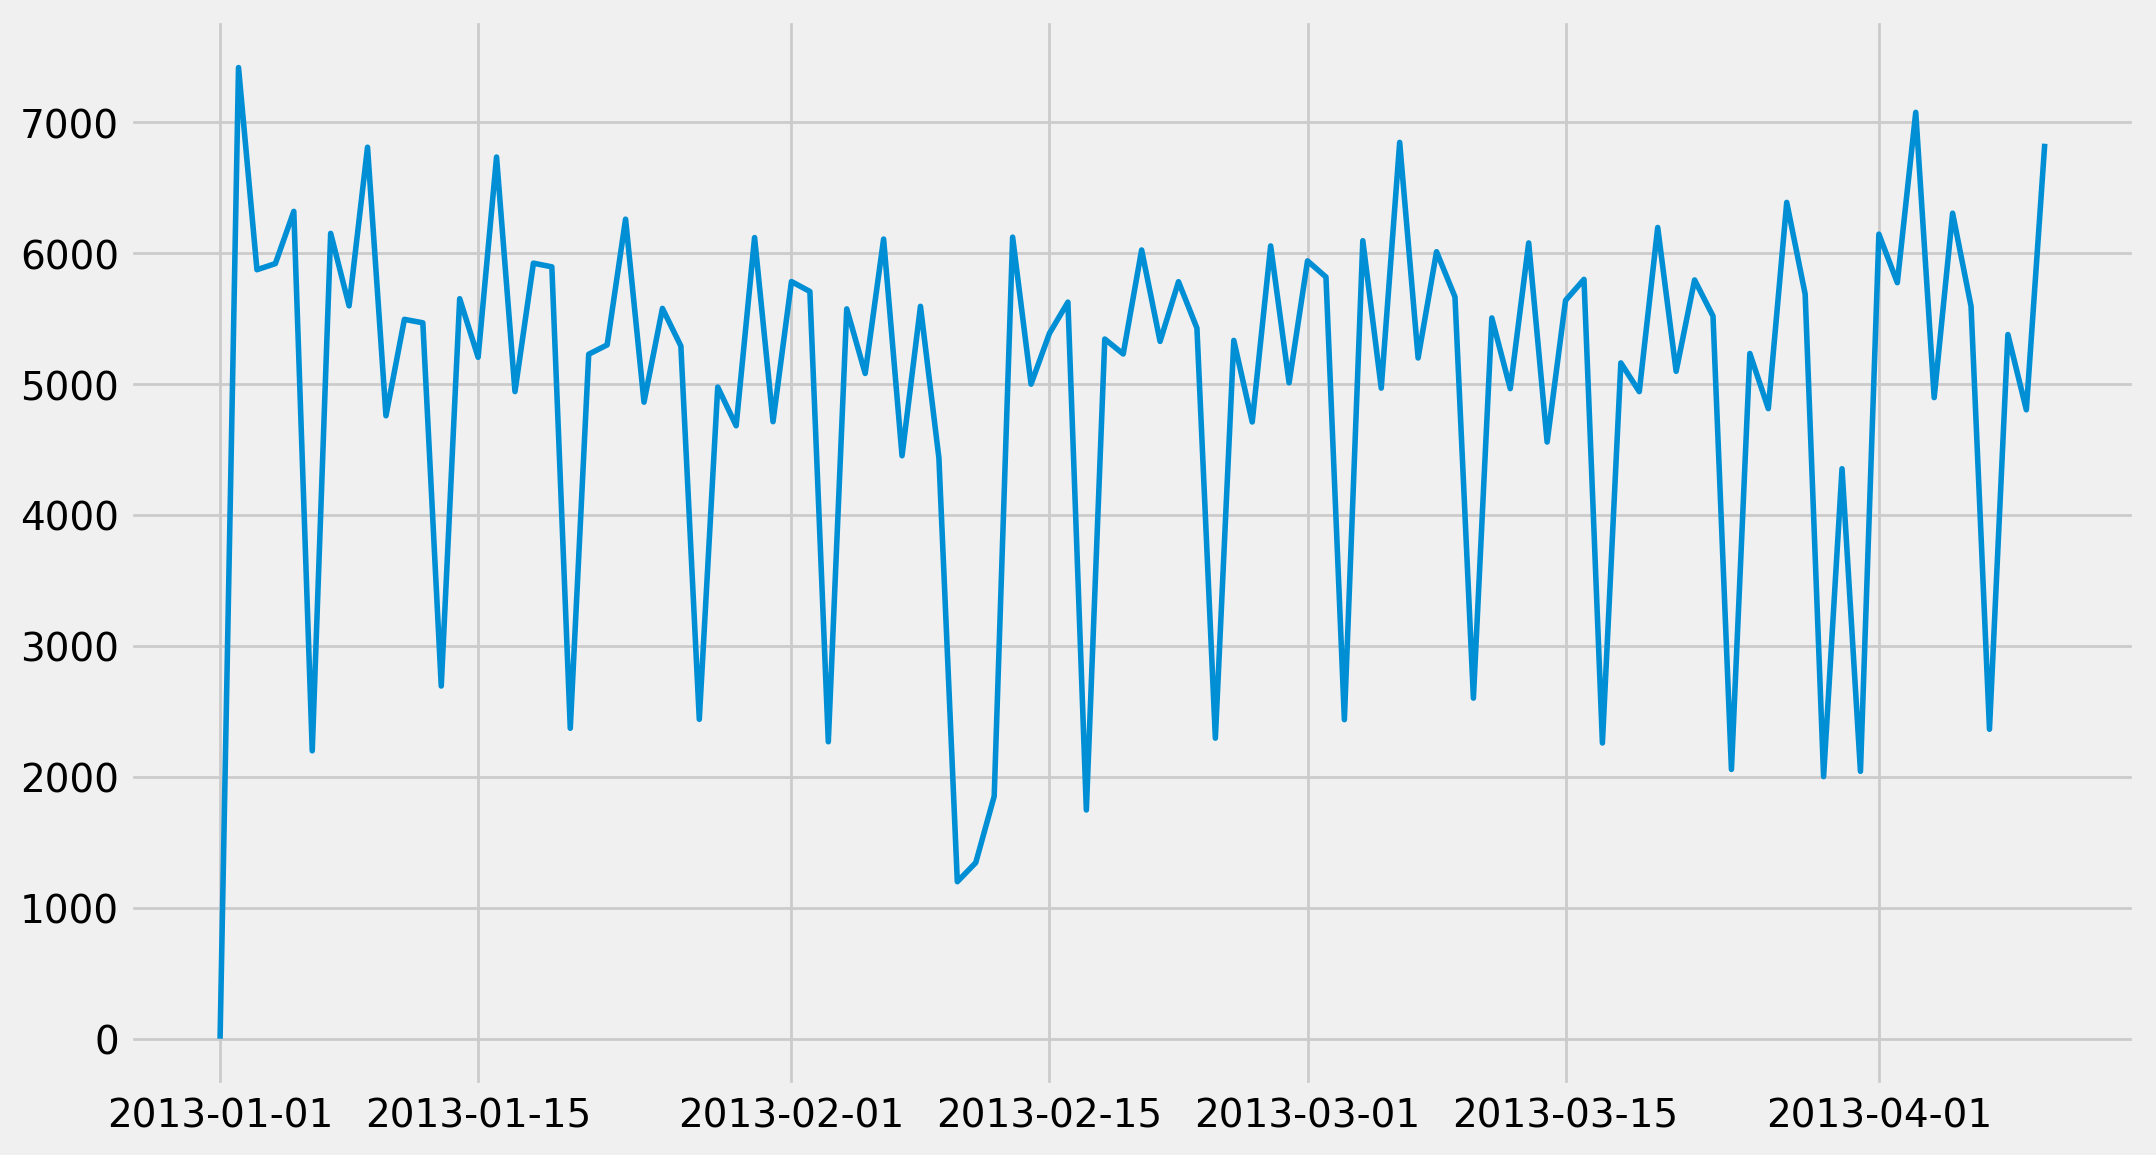

In [6]:
y = sales_per_store[1][:100]
y.index.to_period("D")
plt.plot(y.index.array, y)

In [7]:
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [8]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

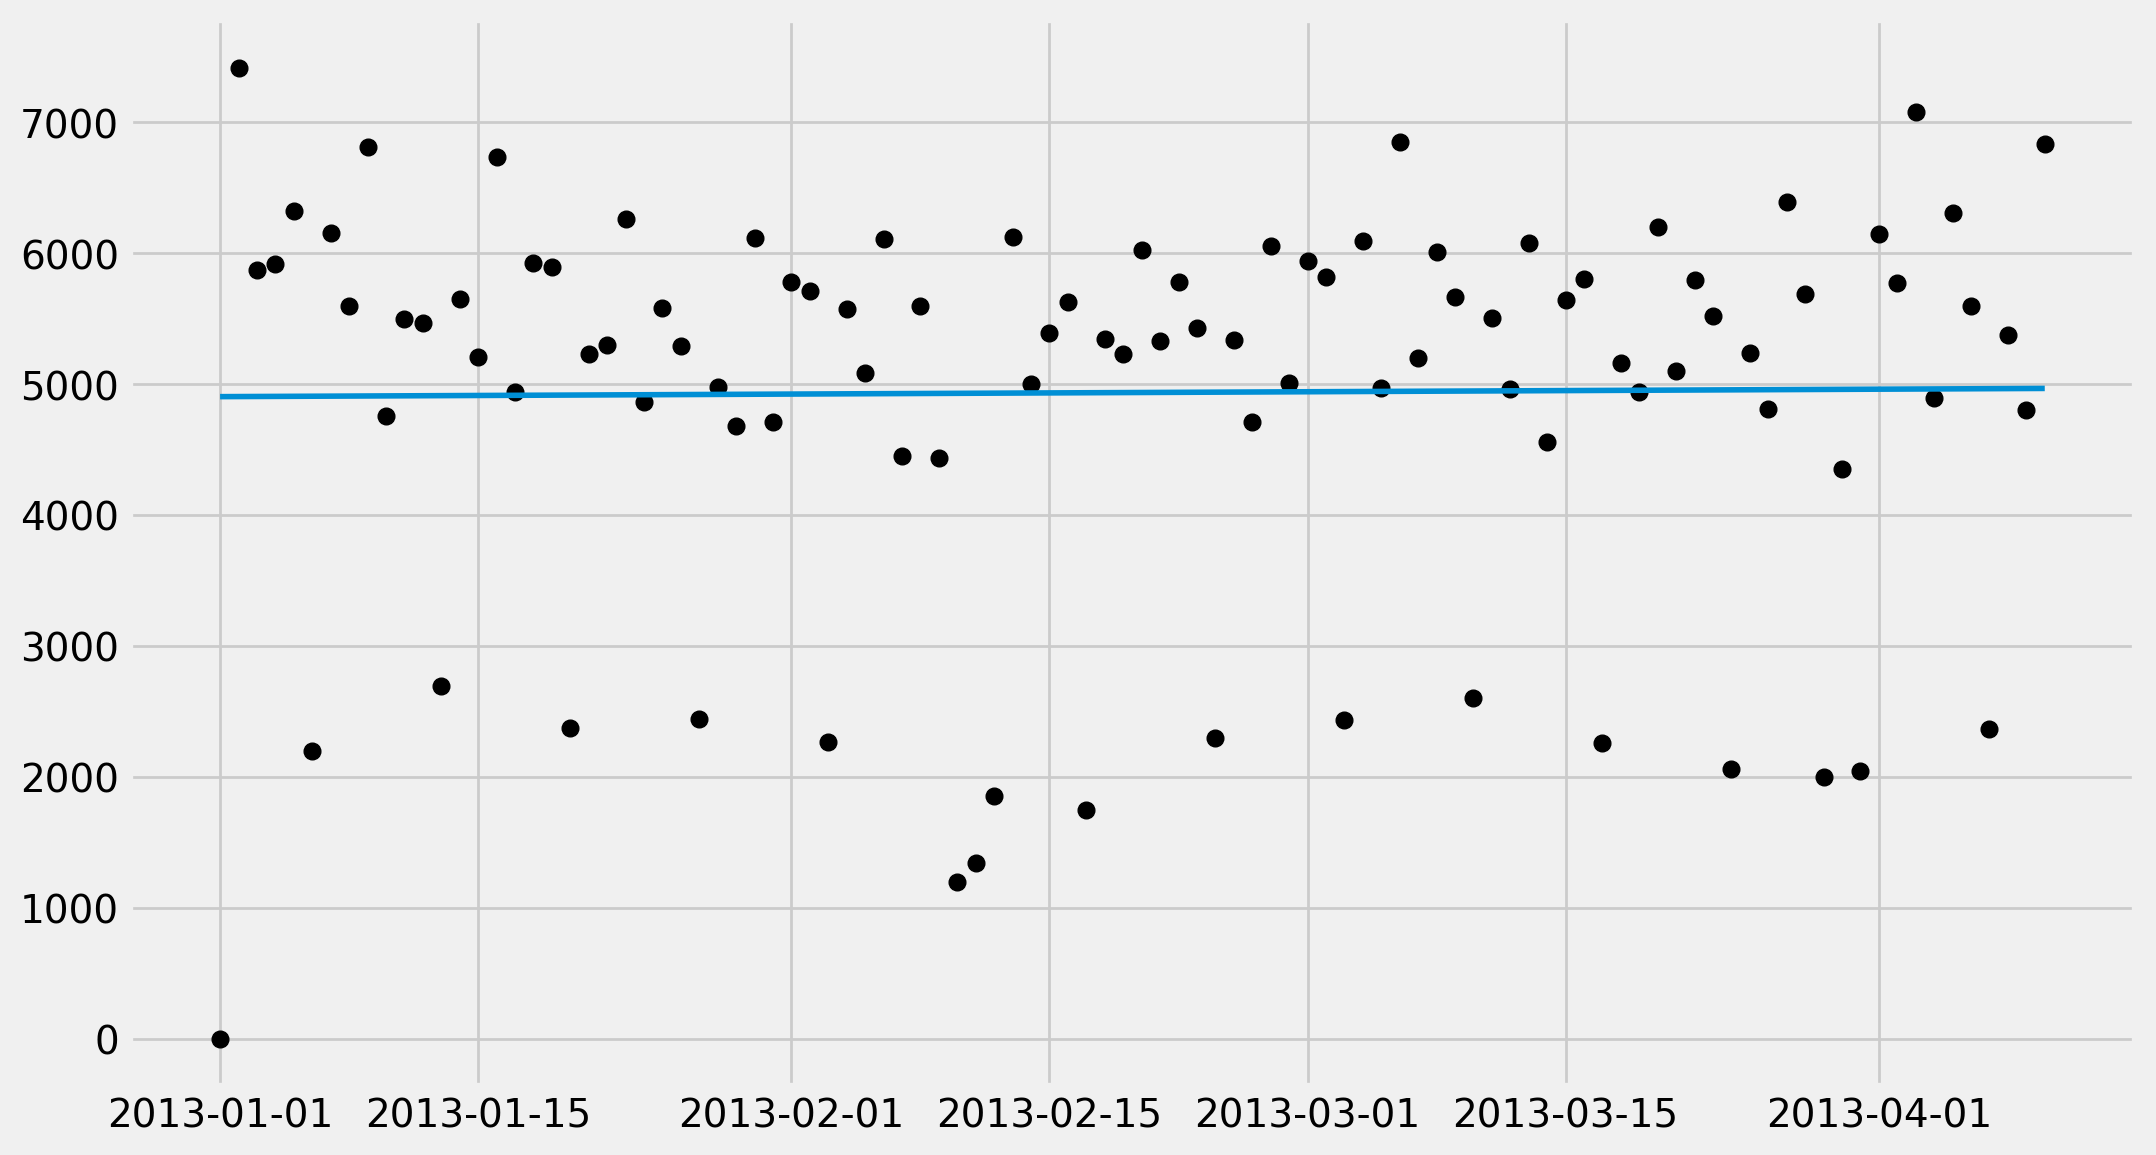

In [9]:
fig, ax = plt.subplots()

ax = plt.plot(y.index, y_pred)
ax = plt.scatter(y.index, y, color='black')

In [10]:
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_fore.head()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


101    4967.130777
102    4967.764053
103    4968.397330
104    4969.030606
105    4969.663882
dtype: float64

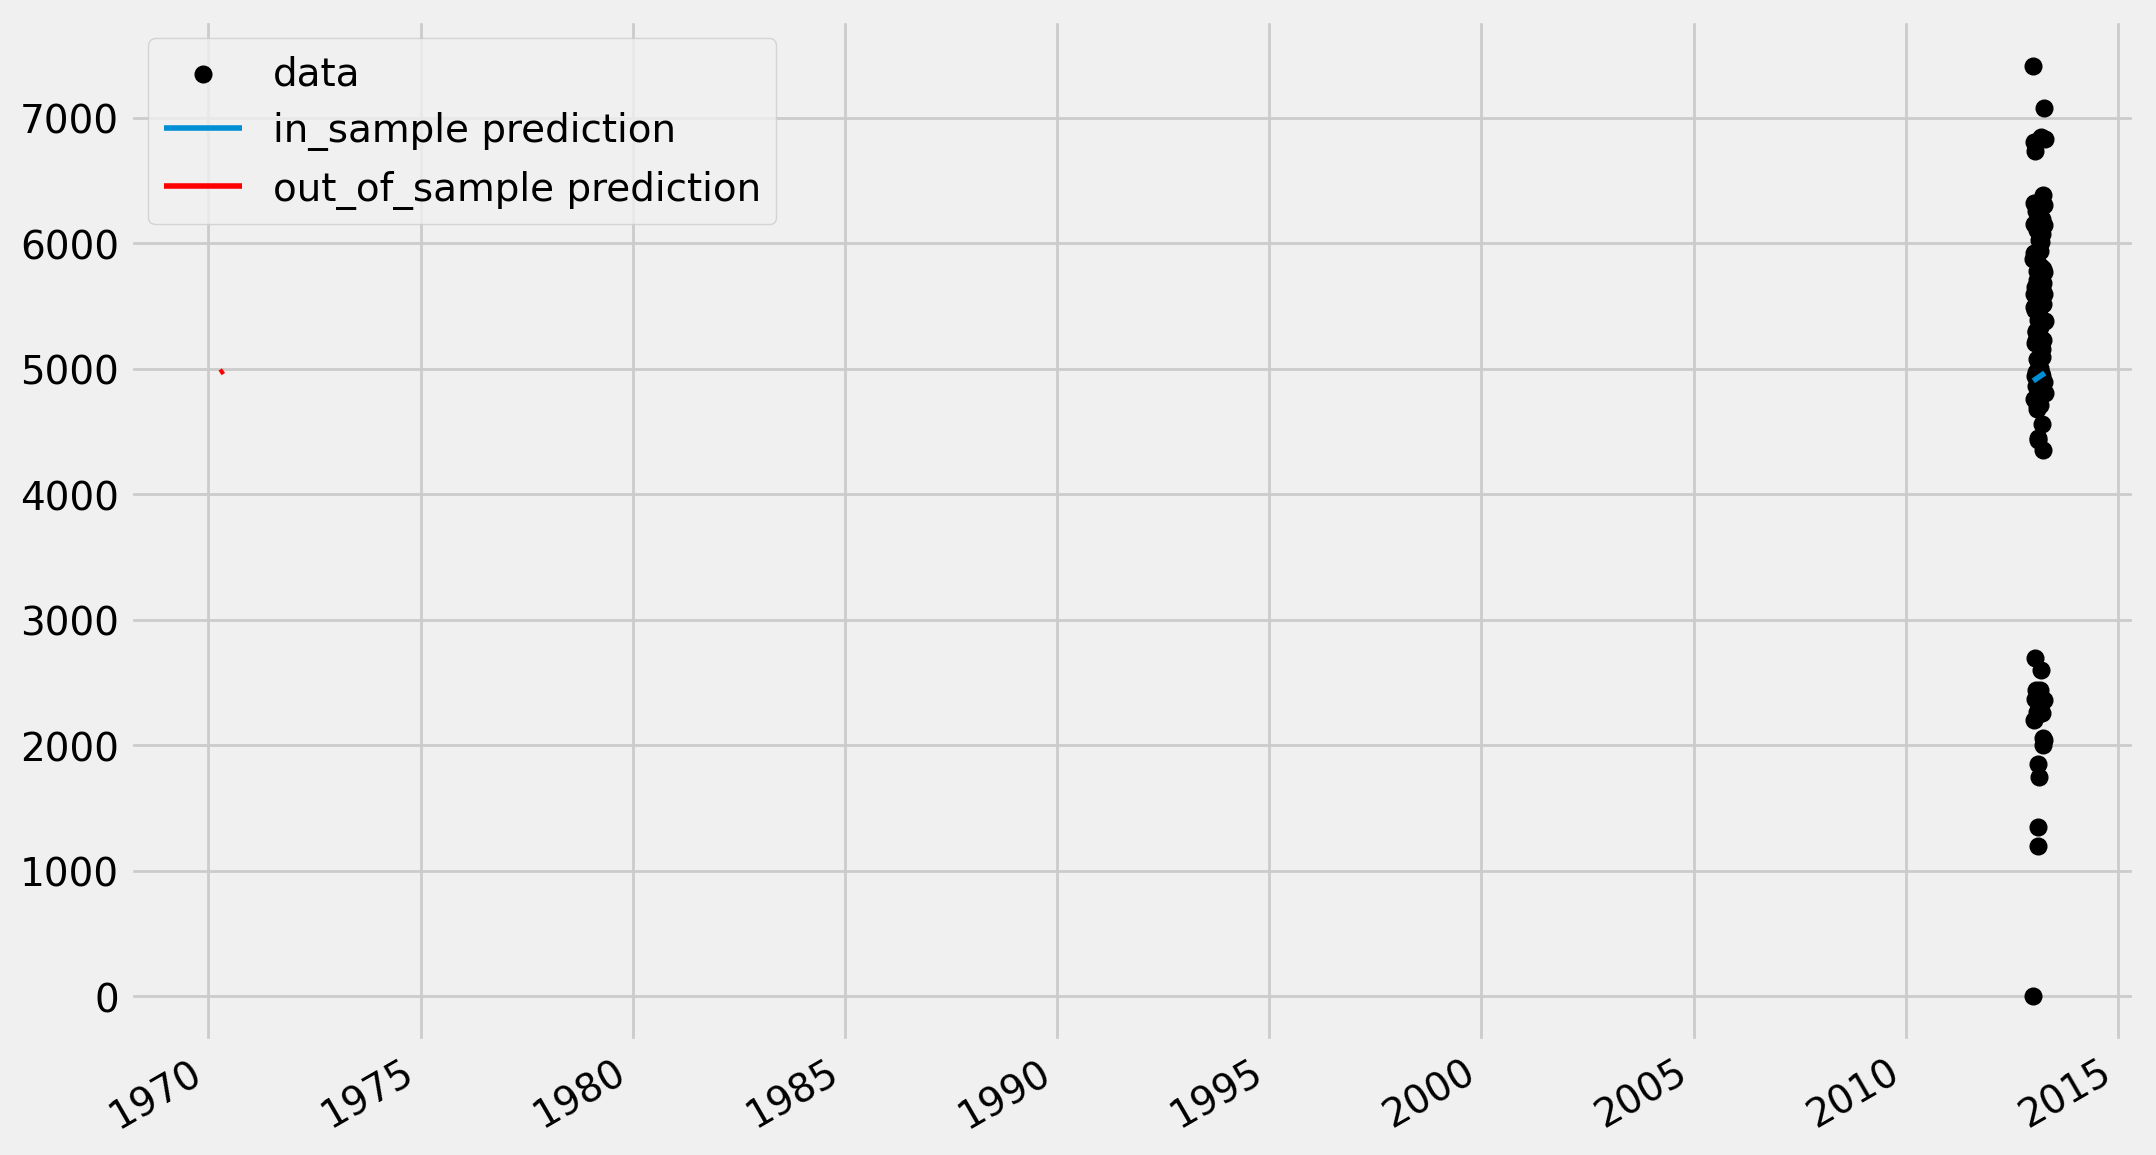

In [11]:
fig, ax = plt.subplots()

fig.autofmt_xdate()

ax = plt.scatter(y.index, y, color='black', label='data')
ax = plt.plot(y.index, y_pred, label='in_sample prediction')
ax = plt.plot(y_fore.index, y_fore, color='red', label='out_of_sample prediction')
plt.legend()